# Projeto - Criando modelos com Python e Machine Learning para prever a evolução do COVID-19 no Brasil

**Bootcamp**: Geração Tech Unimed-BH - Ciência de Dados **Instituição**: DIO - Digital Innovation One

Professor: Neylson Crepalde

### Aluno:

* [Jeremias Diefenthaler](https://github.com/JeremiasDief)

### Instruções e Objetivos:

>> Neste Labs, vamos investigar os dados da disseminação do COVID-19 no Brasil desde o início da pandemia em fevereiro de 2020. Iremos estudar os padrões de disseminação da doença, investigar os números de infectados, de recuperados e de óbitos, para construir modelos com Python e Machine Learning para prever os números nos próximos dias e o ponto de virada da curva de infecção baseado em alguns cenários.

### Local de extração do dataset utilizado:

https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset

In [1]:
# Importando as bibliotecas necessárias para o desenvolvimento do projeto

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Criando o dataset a partir de um arquivo csv (extraído do link na descrição do projeto)

df = pd.read_csv("covid_19_data.csv", parse_dates=["ObservationDate", "Last Update"])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,2021-05-29,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,2021-05-29,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,2021-05-29,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,2021-05-29,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [3]:
# Verificando os tipos de cada coluna

df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [4]:
# Renomeando as colunas com espaço e "/"

df.columns = [re.sub(r"[/| ]", "_", col_name).lower() for col_name in df.columns]
df

,sno,observationdate,province_state,country_region,last_update,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,2021-05-29,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,2021-05-29,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,2021-05-29,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,2021-05-29,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [5]:
# Separando apenas os dados do Brasil e criando um novo dataset

df_brasil = df.loc[(df["country_region"]=="Brazil") & (df["confirmed"]>0)]
df_brasil

,sno,observationdate,province_state,country_region,last_update,confirmed,deaths,recovered
2525,2526,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2631,2632,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2742,2743,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2852,2853,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2981,2982,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306272,306273,2021-05-29,Roraima,Brazil,2021-05-30 04:20:55,103222.0,1635.0,96188.0
306290,306291,2021-05-29,Santa Catarina,Brazil,2021-05-30 04:20:55,965277.0,15174.0,921496.0
306292,306293,2021-05-29,Sao Paulo,Brazil,2021-05-30 04:20:55,3254893.0,111123.0,2895697.0
306298,306299,2021-05-29,Sergipe,Brazil,2021-05-30 04:20:55,233932.0,5054.0,208146.0


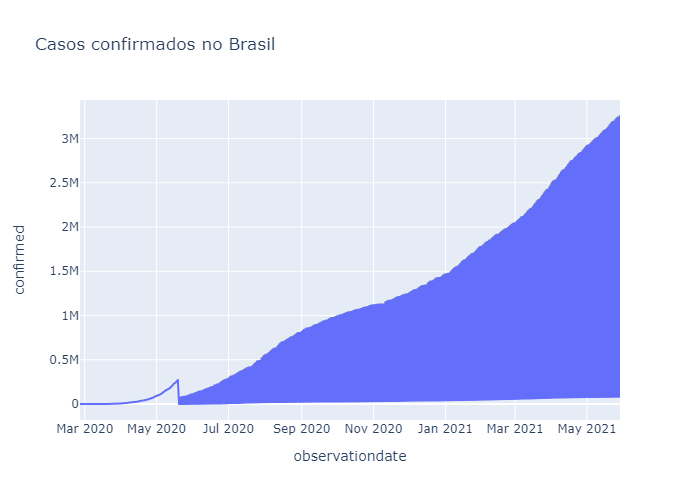

In [6]:
# Visualizando o crescimentos de casos confirmados no Brasil ao longo do tempo, a partir de fevereiro de 2020

fig = px.line(df_brasil, "observationdate", "confirmed", title="Casos confirmados no Brasil")
fig.show("png")

>>> *__Podemos verificar pelo gráfico acima dos casos confirmados por data de observação no Brasil, que há uma quebra no mês de maio de 2020 (mais precisamente do dia 19/05/20 para o dia 20/05/2020). Isso ocorreu porque até o dia 19/05/20 as contagens de casos no Brasil estavam sendo feitas considerando o país inteiro, e a partir do dia 20/05/20 a contagem começou a ser registrada por estado (província).__*

In [7]:
# Primeiro dia com o registro das contagens feito por estado

df_brasil.loc[df_brasil["observationdate"]=="2020-05-20"]

,sno,observationdate,province_state,country_region,last_update,confirmed,deaths,recovered
27258,27259,2020-05-20,Acre,Brazil,2021-04-02 15:13:53,2817.0,76.0,0.0
27261,27262,2020-05-20,Alagoas,Brazil,2021-04-02 15:13:53,4437.0,251.0,0.0
27264,27265,2020-05-20,Amapa,Brazil,2021-04-02 15:13:53,4549.0,142.0,0.0
27265,27266,2020-05-20,Amazonas,Brazil,2021-04-02 15:13:53,23704.0,1561.0,0.0
27281,27282,2020-05-20,Bahia,Brazil,2021-04-02 15:13:53,11197.0,362.0,0.0
27307,27308,2020-05-20,Ceara,Brazil,2021-04-02 15:13:53,30560.0,1900.0,0.0
27324,27325,2020-05-20,Distrito Federal,Brazil,2021-04-02 15:13:53,5161.0,77.0,0.0
27327,27328,2020-05-20,Espirito Santo,Brazil,2021-04-02 15:13:53,8092.0,341.0,0.0
27340,27341,2020-05-20,Goias,Brazil,2021-04-02 15:13:53,1978.0,78.0,0.0
27387,27388,2020-05-20,Maranhao,Brazil,2021-04-02 15:13:53,15114.0,634.0,0.0


In [8]:
# Editando o dataset do Brasil para começar no dia 20/05/2020, data em que os registros começaram a serem feitos por estado

df_brasil = df.loc[(df["country_region"]=="Brazil") & (df["confirmed"]>0) & (df["observationdate"]>="2020/05/20")]
df_brasil

,sno,observationdate,province_state,country_region,last_update,confirmed,deaths,recovered
27258,27259,2020-05-20,Acre,Brazil,2021-04-02 15:13:53,2817.0,76.0,0.0
27261,27262,2020-05-20,Alagoas,Brazil,2021-04-02 15:13:53,4437.0,251.0,0.0
27264,27265,2020-05-20,Amapa,Brazil,2021-04-02 15:13:53,4549.0,142.0,0.0
27265,27266,2020-05-20,Amazonas,Brazil,2021-04-02 15:13:53,23704.0,1561.0,0.0
27281,27282,2020-05-20,Bahia,Brazil,2021-04-02 15:13:53,11197.0,362.0,0.0
...,...,...,...,...,...,...,...,...
306272,306273,2021-05-29,Roraima,Brazil,2021-05-30 04:20:55,103222.0,1635.0,96188.0
306290,306291,2021-05-29,Santa Catarina,Brazil,2021-05-30 04:20:55,965277.0,15174.0,921496.0
306292,306293,2021-05-29,Sao Paulo,Brazil,2021-05-30 04:20:55,3254893.0,111123.0,2895697.0
306298,306299,2021-05-29,Sergipe,Brazil,2021-05-30 04:20:55,233932.0,5054.0,208146.0


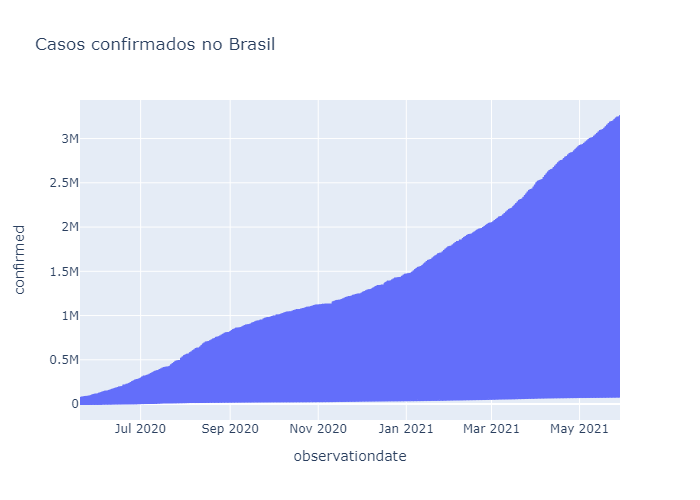

In [9]:
# Nova visualização após a edição

fig = px.line(df_brasil, "observationdate", "confirmed", title="Casos confirmados no Brasil")
fig.show("png")

In [10]:
# Agrupando os dados por data de observação e somando todos os registros dos estados por dia

df_brasil = df_brasil.groupby(["observationdate"], as_index=False)[["confirmed", "deaths", "recovered"]].sum()
df_brasil

,observationdate,confirmed,deaths,recovered
0,2020-05-20,291579.0,18859.0,0.0
1,2020-05-21,310087.0,20047.0,0.0
2,2020-05-22,330890.0,21048.0,0.0
3,2020-05-23,347398.0,22013.0,0.0
4,2020-05-24,363211.0,22666.0,0.0
...,...,...,...,...
370,2021-05-25,16194209.0,452031.0,14231991.0
371,2021-05-26,16274695.0,454429.0,14272174.0
372,2021-05-27,16342162.0,456674.0,14455810.0
373,2021-05-28,16391930.0,459045.0,14492701.0


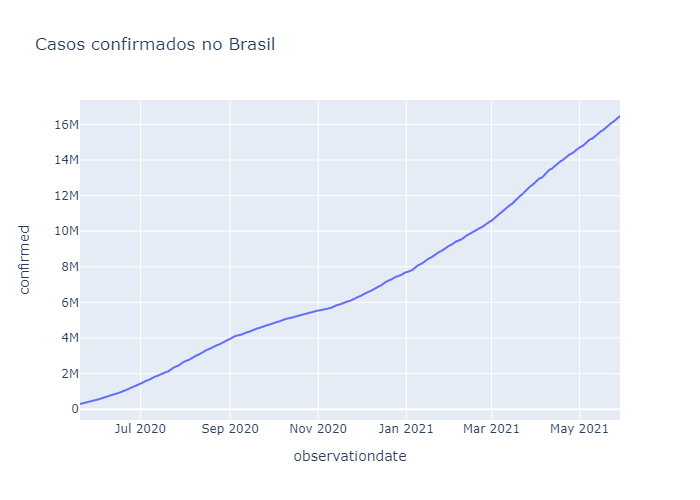

In [11]:
# Visualizando novamente

fig = px.line(df_brasil, "observationdate", "confirmed", title="Casos confirmados no Brasil")
fig.show("png")

In [12]:
# Verificando o shape do dataset com os dados brasileiros: Podemos ver que existem 375 datas (número de linhas)

df_brasil.shape

(375, 4)

In [13]:
# Criando a coluna "novos_casos" que diz a quantidade de novos casos a cada dia

df_brasil["novos_casos"] = list(map(
    lambda x: 0 if (x==0) else df_brasil["confirmed"].iloc[x] - df_brasil["confirmed"].iloc[x-1],
    np.arange(df_brasil.shape[0])
))

In [14]:
# Visualizando o dataset com a nova coluna

df_brasil

,observationdate,confirmed,deaths,recovered,novos_casos
0,2020-05-20,291579.0,18859.0,0.0,0.0
1,2020-05-21,310087.0,20047.0,0.0,18508.0
2,2020-05-22,330890.0,21048.0,0.0,20803.0
3,2020-05-23,347398.0,22013.0,0.0,16508.0
4,2020-05-24,363211.0,22666.0,0.0,15813.0
...,...,...,...,...,...
370,2021-05-25,16194209.0,452031.0,14231991.0,73453.0
371,2021-05-26,16274695.0,454429.0,14272174.0,80486.0
372,2021-05-27,16342162.0,456674.0,14455810.0,67467.0
373,2021-05-28,16391930.0,459045.0,14492701.0,49768.0


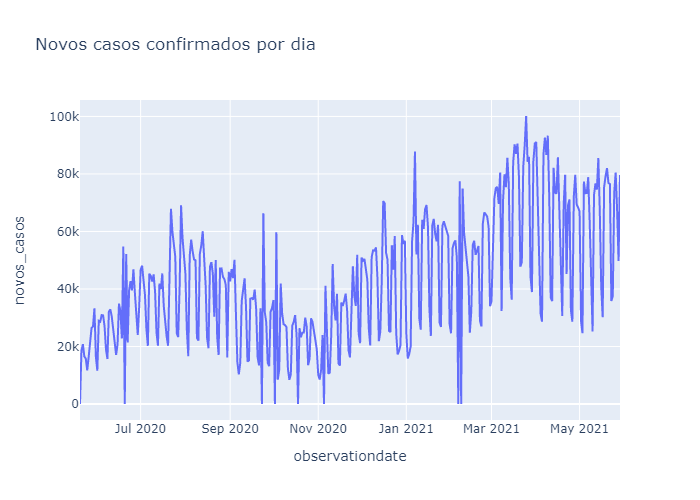

In [15]:
# Visualizando o número de novos casos por dia

fig = px.line(df_brasil, "observationdate", "novos_casos", title="Novos casos confirmados por dia")
fig.show("png")

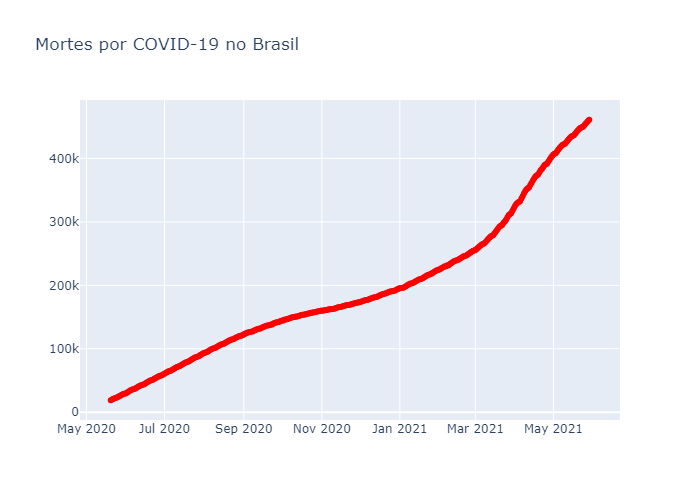

In [16]:
# Visualizando o crescimento do número de mortes por dia

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_brasil["observationdate"], y=df_brasil["deaths"], name="Mortes",
               mode="lines+markers", line={"color":"red"})
)

# Layout
fig.update_layout(title="Mortes por COVID-19 no Brasil")

fig.show("png")

### Taxa de crescimento

 - taxa_crescimento = (presente/passado)**(1/n) - 1

In [17]:
# Função para determinar a taxa de crescimento durante algum período analisado (neste caso, no período do dataset)

def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable]>0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
        
    # Define os valores do presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo que vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcular a taxa de crescimento
    taxa = (presente / passado)**(1/n) - 1
    
    return taxa*100

In [18]:
# Taxa de crescimento de casos confirmados no Brasil no período de 20/05/2020 até 29/05/2021

taxa_crescimento(df_brasil, "confirmed")

1.0844697485237198

In [19]:
# Função para determinar a taxa de crescimento diário

def taxa_crescimento_diario(data, variable, data_inicio=None):
    # Se data_inicio for None, define como a primeira data disponível
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable]>0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.iloc[-1]
    
    # Define o número de pontos no tempo que vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Taxa calculada de um dia para o outro
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1, n+1)
    ))
    
    return np.array(taxas) * 100

In [20]:
# Taxa de crescimento diário para os casos confirmados no Brasil

tx_dia = taxa_crescimento_diario(df_brasil, "confirmed")

In [21]:
# Valores da taxa diária de crescimentos dos casos confirmados no Brasil

tx_dia

array([6.34750788, 6.70876238, 4.98896914, 4.55183968, 3.21768889,
       4.35425102, 5.26529694, 6.41468016, 6.14460636, 7.15314533,
       3.29207126, 2.25269934, 5.49646973, 5.15554131, 5.29523164,
       5.0134891 , 4.19266272, 2.81074718, 2.2629301 , 4.53639463,
       4.45069188, 3.93725661, 3.23630965, 2.61869427, 2.01172467,
       2.37971748, 3.93100754, 3.48661   , 2.38282898, 5.59949373,
       0.        , 5.04640759, 1.97523036, 3.56412736, 3.72849082,
       3.32172053, 3.81560669, 3.03480698, 2.31991821, 1.78939294,
       2.47377019, 3.33171427, 3.32044179, 2.82077525, 2.46400287,
       1.65192986, 1.26190305, 2.79094724, 2.67117906, 2.48774195,
       2.56569876, 2.16694885, 1.34962089, 1.08790726, 2.22056938,
       2.07201073, 2.30853165, 1.69853058, 1.39430238, 1.13400422,
       0.96535962, 1.93557583, 3.14217   , 2.69183493, 2.44334911,
       2.1826296 , 1.02643001, 0.9625103 , 1.67116024, 2.78166279,
       2.26610481, 2.00693306, 1.70487345, 0.95277592, 0.60874

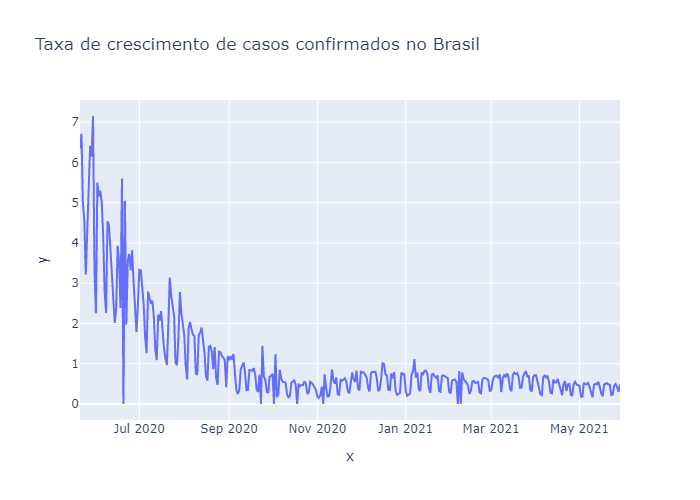

In [22]:
# Visualizando a taxa diária de crescimentos dos casos confirmados no Brasil

primeiro_dia = df_brasil["observationdate"].loc[df_brasil["confirmed"]>0].min()

fig = px.line(x=pd.date_range(primeiro_dia, df_brasil["observationdate"].max())[1:],
              y=tx_dia, title="Taxa de crescimento de casos confirmados no Brasil")
fig.show("png")

### Predições

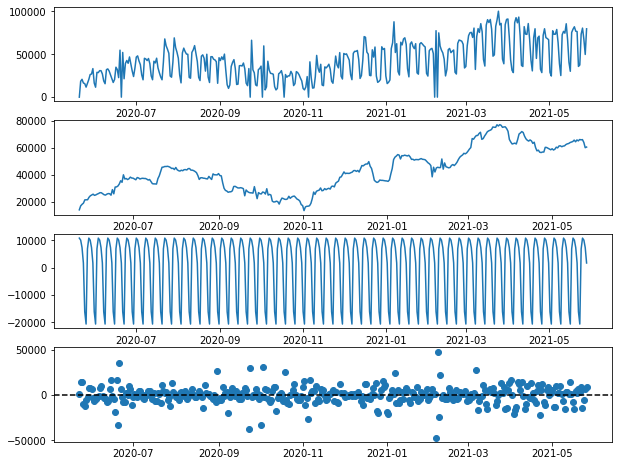

In [24]:
# Decompondo a serie de novos casos

novoscasos = df_brasil.novos_casos
novoscasos.index = df_brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

In [25]:
# Criando uma Serie apenas com a coluna de casos confirmados no Brasil, e transformando a data em índice

df_confirmados = df_brasil["confirmed"]
df_confirmados.index = df_brasil["observationdate"]
df_confirmados

observationdate
2020-05-20      291579.0
2020-05-21      310087.0
2020-05-22      330890.0
2020-05-23      347398.0
2020-05-24      363211.0
                 ...    
2021-05-25    16194209.0
2021-05-26    16274695.0
2021-05-27    16342162.0
2021-05-28    16391930.0
2021-05-29    16471600.0
Name: confirmed, Length: 375, dtype: float64

In [26]:
# Decompondo a serie de casos confirmados

resultado = seasonal_decompose(df_confirmados)

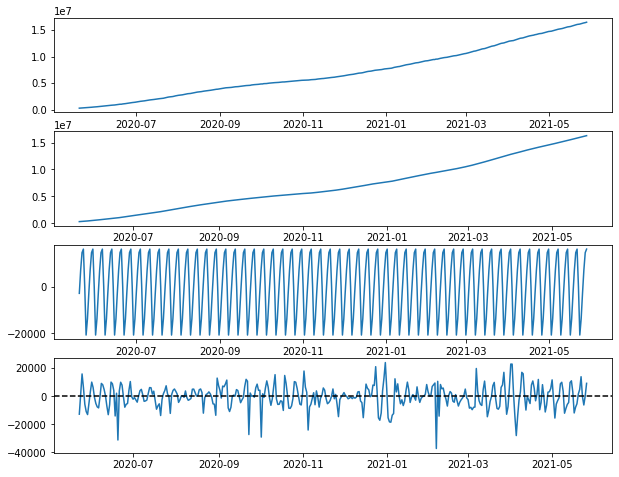

In [27]:
# Visualizando o resultado da decomposição da serie de casos confirmados

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))

ax1.plot(resultado.observed)
ax2.plot(resultado.trend)
ax3.plot(resultado.seasonal)
ax4.plot(resultado.resid)
ax4.axhline(0, linestyle="dashed", c="black")

plt.show()

### Modelagem com AUTO-ARIMA

In [28]:
# Criando o modelo com auto-arima

modelo = auto_arima(df_confirmados)

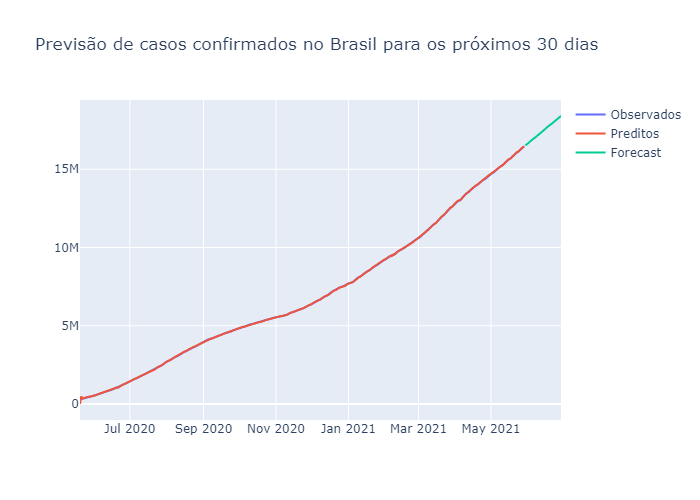

In [29]:
# Visualizando a predição

fig = go.Figure(go.Scatter(
    x=df_confirmados.index, y=df_confirmados, name="Observados"
))

fig.add_trace(go.Scatter(
    x=df_confirmados.index, y=modelo.predict_in_sample(), name="Preditos"
))

fig.add_trace(go.Scatter(
    x=pd.date_range("2021-05-30", "2021-06-30"), y=modelo.predict(31), name="Forecast"
))

fig.update_layout(title="Previsão de casos confirmados no Brasil para os próximos 30 dias")
fig.show("png")

### Modelo de crescimento com Facebook Prophet

Usando a biblioteca fbprophet

In [30]:
# Caso seja necessário instalar a biblioteca, esta foi a melhor maneira encontrada

#!conda install -c conda-forge fbprophet -y

In [31]:
# Importando o Prophet da biblioteca fbprophet

from fbprophet import Prophet

In [34]:
# Preprocessamentos
train = df_confirmados.reset_index()[:-80] 
test = df_confirmados.reset_index()[-80:]   # Teste com aproximadamente 20% do dataset

# Renomeado colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

# Definir o modelo de crescimento
profeta = Prophet(growth="logistic")

# População brasileira
pop = 215268767 # Coletado em 25/10/2022, às 18:12
train["cap"] = pop

# Treina o modelo
profeta.fit(train)

# Construir previsões para o futuro
future = profeta.make_future_dataframe(periods=200)
future["cap"] = pop
forecast = profeta.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


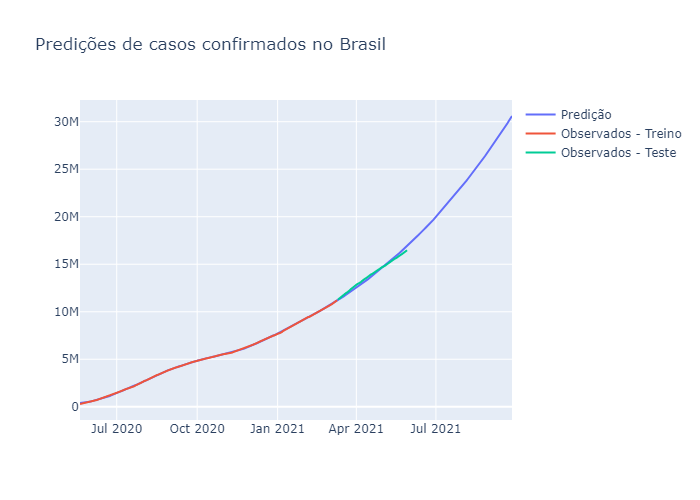

In [35]:
# Visualizando a predição feita pelo Prophet

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name="Predição"))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name="Observados - Treino"))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.update_layout(title="Predições de casos confirmados no Brasil")
fig.show("png")

----------------------
----------------------
-------------------------

## Conclusões:

 - Modelagem de séries temporais pode ser bem eficiente utilizando bibliotecas como ARIMA e FBPROPHET;
 - Porém, é necessário ter alguns cuidados na etapa de preparação dos dados como verificar e ajustar o tipo de dados das datas, transformá-las para índices quando necessário, criar ou ajustar colunas para que sejam mais condizentes com aquilo que estamos querendo prever, e o que mais for preciso para termos uma boa análise.